In [1]:
import sys
sys.path.append("..")  # Ensure project root is found

# Import configurations
from configs.plot_config import apply_plot_settings
from configs.math_functions import F, lognormal
from configs.parameters import *
from configs.filenames import *

import matplotlib.pyplot as plt
import numpy as np
import os

C = float(os.getenv("C", C))
sig = float(os.getenv("sig", sig))
itr = int(os.getenv("itr", itr))

print(f"📢 Using parameters: C={C}, sig={sig}, itr={itr}")

📢 Using parameters: C=0.01, sig=0.14, itr=20000


In [2]:
output_dir = "../data/"

lower_bound = int(30/dt)
upper_bound = int(80/dt)


params = get_params_for_filename(param_keys, globals())
filename = get_filename("lognormal", "WCM", **params)
savefile = os.path.join(output_dir, filename)
data = np.load(savefile, allow_pickle=True)      
tt, synEE, synII, EE, II = data[lower_bound:upper_bound,0], data[lower_bound:upper_bound,1], data[lower_bound:upper_bound,2], data[lower_bound:upper_bound,3], data[lower_bound:upper_bound,4]
print(f"✅ Opened {savefile}")

params = get_params_for_filename(param_keys, globals())
filename = get_filename("lognormal", "PRC", **params)
savefile = os.path.join(output_dir, filename)
data = np.load(savefile, allow_pickle=True)      
tt, synEE_PRC, synII_PRC, ZE, ZI = data[lower_bound:upper_bound,0], data[lower_bound:upper_bound,1], data[lower_bound:upper_bound,2], data[lower_bound:upper_bound,3], data[lower_bound:upper_bound,4]
print(f"✅ Opened {savefile}")

✅ Opened ../data/WCM_LOGNORMAL_delay_itr=20000_dt=0.005_tau=1_sig=0.14_wee=20_wei=21_wie=16_wii=6_ie=1.5_ii=-0.5_E0=0_I0=0.npy
✅ Opened ../data/PRC_WCM_LOGNORMAL_delay_itr=20000_dt=0.005_tau=1_sig=0.14_wee=20_wei=21_wie=16_wii=6_ie=1.5_ii=-0.5_ZE1=-5_ZI1=1.npy


In [3]:
RANGE = int(len(tt)/3-1)
print(RANGE)

first_part  = np.array([(ZE * ((EE-np.roll(EE,1))/dt)),\
                        (ZI * ((II-np.roll(II,1)))/dt)])
second_part = np.zeros((2,len(tt)))
norm        = np.zeros((2,len(tt)))

for t in range(RANGE):

    integral_of_convolution = np.zeros((2,2*RANGE))
    
    for s in np.arange(1,t):      
        convolution = [(ZE[t:s+t] * (((wee * F(synEE[t:s+t]) * (1 - F(synEE[t:s+t]))) * ((EE[t-s:t]-EE[t-s-1:t-1])/dt)) + ((-wei * F(synII[t:s+t]) * (1 - F(synII[t:s+t]))) * ((II[t-s:t]-II[t-s-1:t-1])/dt)))),\
                       (ZI[t:s+t] * (((wie * F(synEE[t:s+t]) * (1 - F(synEE[t:s+t]))) * ((EE[t-s:t]-EE[t-s-1:t-1])/dt)) + ((-wii * F(synII[t:s+t]) * (1 - F(synII[t:s+t]))) * ((II[t-s:t]-II[t-s-1:t-1])/dt))))]

        inner_integral = np.sum(convolution, axis = 1) * dt
        integral_of_convolution[:,s] = lognormal(s*dt, np.log(tau), sig) * inner_integral

    second_part[:,t] = np.sum(integral_of_convolution, axis=1) * dt

    norm[:,t] = first_part[:,t] + second_part[:,t]
    print(t, end = '\r')

norm_EE = norm[0,:]
norm_II = norm[1,:]

first_part_EE = first_part[0,:]
first_part_II = first_part[1,:]

second_part_EE = second_part[0,:]
second_part_II = second_part[1,:]

3332


Normalization constant = -5.990


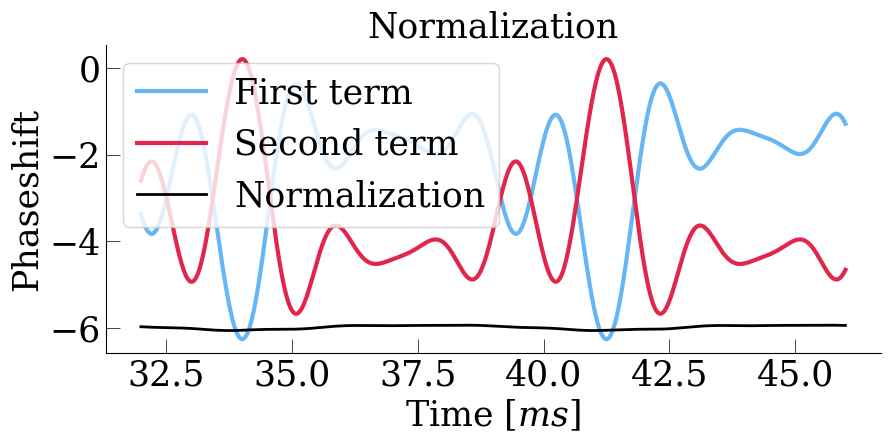

In [4]:
apply_plot_settings()

Norm = norm_EE + norm_II
first_part = first_part_EE + first_part_II
second_part = second_part_EE + second_part_II

# select part without transients
bottom = int(2/dt)
top = int(16/dt)

time = tt[bottom:top]
Norm = Norm[bottom:top]
first_part = first_part[bottom:top]
second_part = second_part[bottom:top]

Norm_constant = np.mean(Norm[:])
print('Normalization constant =', '{0:.3f}'.format(Norm_constant))

fig, ax = plt.subplots(figsize=(10, 4)) 

ax.plot(time, first_part, linewidth=3, label = 'First term', color = "#66B5F4")
ax.plot(time, second_part, linewidth=3, label = 'Second term', color = "#E2254B")
ax.plot(time, Norm, linewidth=2, label='Normalization', color = "black")
ax.set_xlabel('Time $[ms]$')
ax.set_ylabel('Phaseshift')
ax.set_title('Normalization')
ax.legend()

plt.show()

In [5]:
params = get_params_for_filename(param_keys, globals())
filename = get_filename("lognormal", "PRC", **params)
savefile = os.path.join(output_dir, filename)
data = np.load(savefile, allow_pickle=True)      
tt, synEE, synII, ZE, ZI = data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]

ZE_normalized = ZE / Norm_constant
ZI_normalized = ZI / Norm_constant

data = np.column_stack((tt, ZE_normalized, ZI_normalized))

params = get_params_for_filename(param_keys, globals())
filename = get_filename("lognormal", "Normalized_PRC", **params)
savefile = os.path.join(output_dir, filename)
np.save(savefile, data, allow_pickle=True)

print(f"✅ Data saved to {savefile}")

✅ Data saved to ../data/Normalized_PRC_LOGNORMAL_delay_itr=20000_dt=0.005_tau=1_sig=0.14_wee=20_wei=21_wie=16_wii=6_ie=1.5_ii=-0.5_ZE1=-5_ZI1=1.npy
